In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
from IPython.display import display
from sklearn.externals import joblib

basepath = os.path.expanduser('../')

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## EDA Ideas

1. Isolate a single client's information.
1. Calculate difference between application amount and sum of amount paid in installments.
1. Treat status in bureau balance as string of characters.
1. Most recent months balance info from pos_cash table.
1. Difference between Days_credit_enddate and Days_enddate_fact for closed loans reported to Bureau.
1. Ratio of AMT_CREDIT_SUM to duration for closed credits.
1. Ratio of AMT_CREDIT_MAX_OVERDUE to AMT_CREDIT_SUM for closed credits.

## Load Data

In [4]:
%%time

app_train   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_train.pkl'))
app_test    = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_test.pkl'))

# additional tables

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau.pkl'))
bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau_balance.pkl'))
prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/previous_application.pkl'))
installments = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/installments_payments.pkl')) 
pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/POS_CASH_balance.pkl'))
credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/credit_card_balance.pkl'))

CPU times: user 446 ms, sys: 2.11 s, total: 2.56 s
Wall time: 33 s


In [5]:
app_train.TARGET.value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

### Isolate a single client's information

In [5]:
# defaulter
app_train[app_train.TARGET == 1].sample(n=20)['SK_ID_CURR'].iloc[10:16]

255472    395613
198266    329878
127821    248250
71603     183031
11542     113450
16517     119268
Name: SK_ID_CURR, dtype: int32

In [8]:
display_all(bureau.loc[bureau.SK_ID_CURR == 395613])

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1181170,395613,5522530,Closed,currency 1,-2682,0,-2316.0,-2328.0,NaN,0,45000.0,NaN,NaN,0.0,Consumer credit,-2318,0.0
1181171,395613,5522531,Closed,currency 1,-1786,0,-1421.0,-1423.0,4455.000000,0,45000.0,NaN,NaN,0.0,Consumer credit,-1423,0.0
1181172,395613,5522532,Closed,currency 1,-1154,0,-880.0,-880.0,5331.870117,0,49500.0,0.0,0.0,0.0,Consumer credit,-880,0.0


In [15]:
bureau_bal.loc[bureau_bal.SK_ID_BUREAU.isin([5773025, 5773024])]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS


In [18]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == 329878])

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
928416,2287065,329878,Cash loans,21038.535156,315000.0,366142.5,NaN,315000.0,THURSDAY,12,Y,1,NaN,NaN,NaN,XNA,Approved,-936,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),6,XNA,36.0,high,Cash X-Sell: high,365243.0,-906.0,144.0,-306.0,-303.0,1.0
1137172,2726646,329878,Cash loans,18851.535156,90000.0,92970.0,NaN,90000.0,WEDNESDAY,6,Y,1,NaN,NaN,NaN,XNA,Approved,-1070,Cash through the bank,XAP,"Spouse, partner",New,XNA,Cash,walk-in,AP+ (Cash loan),6,XNA,6.0,high,Cash Street: high,365243.0,-1040.0,-890.0,-920.0,-912.0,1.0
1342522,2447757,329878,Revolving loans,2250.000000,45000.0,45000.0,NaN,45000.0,SATURDAY,7,Y,1,NaN,NaN,NaN,XAP,Approved,-234,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,walk-in,AP+ (Cash loan),6,XNA,0.0,XNA,Card Street,-234.0,-187.0,365243.0,365243.0,365243.0,0.0


In [20]:
display_all(pos_cash.loc[pos_cash.SK_ID_CURR == 329878]\
        .sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, False]))

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
402870,2287065,329878,-10,21.0,0.0,Completed,0,0
374843,2287065,329878,-11,36.0,16.0,Active,0,0
2014774,2287065,329878,-12,36.0,17.0,Active,0,0
593247,2287065,329878,-13,36.0,18.0,Active,0,0
3002066,2287065,329878,-14,36.0,19.0,Active,0,0
3699900,2287065,329878,-15,36.0,20.0,Active,0,0
5269761,2287065,329878,-16,36.0,21.0,Active,0,0
4999414,2287065,329878,-17,36.0,22.0,Active,0,0
2183586,2287065,329878,-18,36.0,23.0,Active,0,0
2192821,2287065,329878,-19,36.0,24.0,Active,1,1


In [10]:
credit_bal.loc[credit_bal.SK_ID_CURR == 395613].sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, False])

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF


In [11]:
installments.loc[installments.SK_ID_CURR == 395613].sort_values(by=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], ascending=[True, True])

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
11271866,2024618,395613,1.0,1,-2198.0,-2200.0,7083.404785,7083.404785
8167379,2024618,395613,1.0,2,-2168.0,-2172.0,7083.404785,7083.404785
8572287,2024618,395613,1.0,3,-2138.0,-2148.0,7083.404785,7083.404785
10281732,2024618,395613,1.0,4,-2108.0,-2106.0,7083.404785,7083.404785
10025801,2024618,395613,1.0,5,-2078.0,-2072.0,7083.404785,7083.404785
7637691,2024618,395613,1.0,6,-2048.0,-2052.0,7083.404785,7083.404785
11420200,2024618,395613,1.0,7,-2018.0,-2018.0,7083.404785,7083.404785
7702068,2024618,395613,1.0,8,-1988.0,-1989.0,7083.404785,7083.404785
8743888,2024618,395613,1.0,9,-1958.0,-1961.0,7083.404785,7083.404785
8244957,2024618,395613,1.0,10,-1928.0,-1926.0,6983.325195,6983.325195


## 2. Difference between credit amount and sum of amount paid in installments.

In [43]:
prev_app_credit  = prev_app[prev_app.NAME_CONTRACT_STATUS == 'Approved'].groupby(['SK_ID_CURR', 'SK_ID_PREV'])['AMT_CREDIT'].sum()
install_amt_paid = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['AMT_PAYMENT'].sum()

In [45]:
diff = prev_app_credit.subtract(install_amt_paid, fill_value=0)
diff.head()

SK_ID_CURR  SK_ID_PREV
100001      1369693        -5463.900391
            1851984       -11945.025391
100002      1038818       -40570.703125
100003      1810518      -115095.375000
            2396755       -12719.882812
dtype: float32

In [59]:
tmp = diff.reset_index().groupby('SK_ID_CURR')[0].min()
tmp = app_train.SK_ID_CURR.map(tmp)
print(tmp[tmp.isnull()].shape[0] / len(tmp))

0.05019007450139995


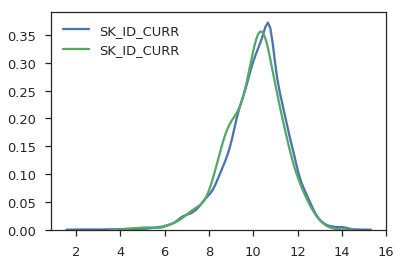

In [60]:
sns.kdeplot(tmp[(tmp > 0) & (app_train.TARGET == 0)].map(np.log1p))
sns.kdeplot(tmp[(tmp > 0) & (app_train.TARGET == 1)].map(np.log1p));

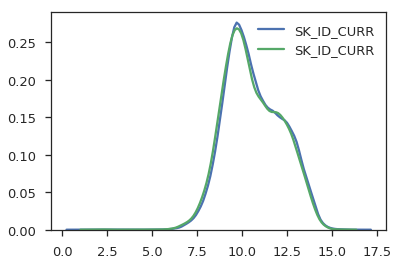

In [61]:
sns.kdeplot((-tmp[(tmp < 0) & (app_train.TARGET == 0)]).map(np.log1p))
sns.kdeplot((-tmp[(tmp < 0) & (app_train.TARGET == 1)]).map(np.log1p));

## Treat status as string of characters

In [6]:
%%time

first_character = bureau_bal.groupby(['SK_ID_BUREAU'])['STATUS'].first()

CPU times: user 3min 59s, sys: 2.14 s, total: 4min 1s
Wall time: 4min 1s


In [9]:
res = bureau.SK_ID_BUREAU.map(first_character)
res[res.isnull()].shape[0] / len(res)

0.5488572780215657

In [21]:
tmp = bureau.groupby(['SK_ID_CURR', res]).size().unstack().fillna(0).astype(np.int).reset_index()
tmp.head()

SK_ID_BUREAU,SK_ID_CURR,0,1,2,3,4,5,C,X
0,100001,2,1,0,0,0,0,4,0
1,100002,2,0,0,0,0,0,6,0
2,100005,1,0,0,0,0,0,1,1
3,100010,0,0,0,0,0,0,2,0
4,100013,0,0,0,0,0,0,3,1


In [25]:
res = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(tmp, on='SK_ID_CURR', how='left')
res = res.fillna(0).astype(np.int)

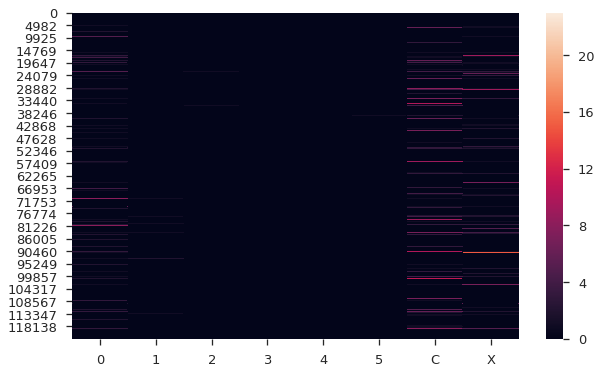

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(res[res.TARGET == 1].iloc[:10000, 2:]);

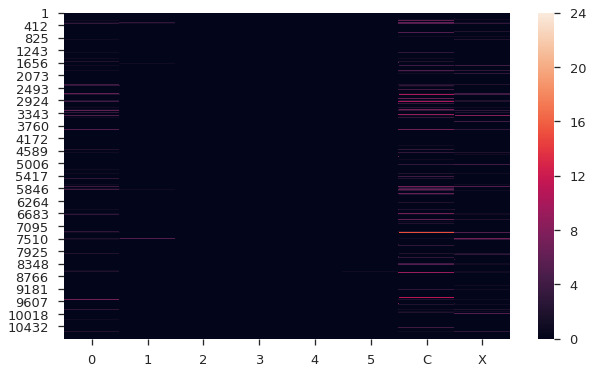

In [41]:
plt.figure(figsize=(10, 6))
sns.heatmap(res[res.TARGET == 0].iloc[:10000, 2:]);

In [19]:
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'SK_ID_BUREAU']]\
            .merge(bureau_bal, on='SK_ID_BUREAU', how='left')

In [38]:
bureau_bal.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [36]:
tmp.loc[:, 'status_unk'] = tmp.STATUS == 'C'

status_unk  = tmp.groupby(['SK_ID_CURR', 'SK_ID_BUREAU'])['status_unk'].sum()
status_size = tmp.groupby(['SK_ID_CURR', 'SK_ID_BUREAU']).size()

res = status_unk / status_size

res = res.reset_index().drop('SK_ID_BUREAU', axis=1)
res = res.groupby('SK_ID_CURR')[0].mean()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.2938463989906052


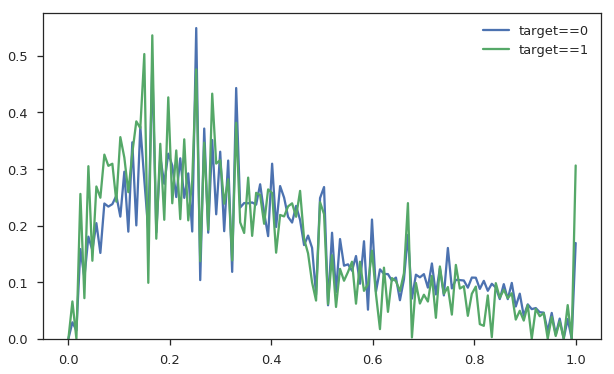

In [37]:
plt.figure(figsize=(10, 6))
sns.kdeplot(res[app_train.TARGET == 0], label='target==0')
sns.kdeplot(res[app_train.TARGET == 1], label='target==1');

## Most recent months balance info from pos_cash table.

In [63]:
prev_app.NAME_CONTRACT_STATUS.value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [64]:
prev_app.NAME_CONTRACT_STATUS.cat.codes.value_counts()

0    1036781
1     316319
2     290678
3      26436
dtype: int64

In [65]:
prev_app.NAME_CONTRACT_TYPE.value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [66]:
prev_app.NAME_CONTRACT_TYPE.cat.codes.value_counts()

0    747553
1    729151
2    193164
3       346
dtype: int64

In [56]:
%%time

m = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
             (prev_app.NAME_CONTRACT_TYPE != 'Revolving loans')
             , ['SK_ID_CURR', 'SK_ID_PREV']]\
        .merge(pos_cash.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE']])

m = m.sort_values(by=['SK_ID_CURR', 'MONTHS_BALANCE'], ascending=[True, False])
f = m.groupby('SK_ID_CURR', as_index=False)['MONTHS_BALANCE'].first()
l = m.groupby('SK_ID_CURR', as_index=False)['MONTHS_BALANCE'].last()

CPU times: user 6.37 s, sys: 1.39 s, total: 7.76 s
Wall time: 7.75 s


In [57]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(f, on='SK_ID_CURR', how='left')
tmp[tmp.MONTHS_BALANCE.isnull()].shape[0] / len(tmp)

0.06680736624055725

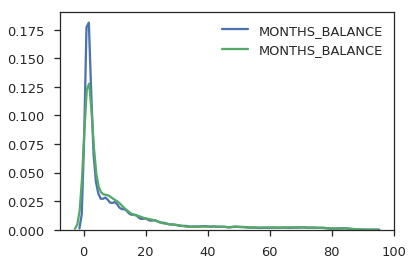

In [58]:
sns.kdeplot(-tmp[tmp.TARGET == 0].MONTHS_BALANCE)
sns.kdeplot(-tmp[tmp.TARGET == 1].MONTHS_BALANCE);

In [59]:
tmp = f['MONTHS_BALANCE'].div(l['MONTHS_BALANCE'])
f.loc[:, 'diff'] = tmp

tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(f.loc[:, ['SK_ID_CURR', 'diff']], on='SK_ID_CURR', how='left')
tmp[tmp['diff'].isnull()].shape[0] / len(tmp)

0.06680736624055725

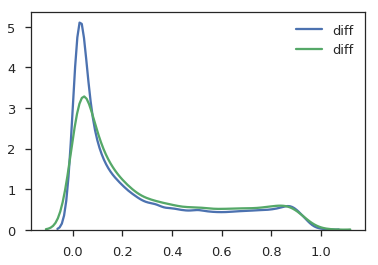

In [60]:
sns.kdeplot(tmp[tmp.TARGET == 0]['diff'])
sns.kdeplot(tmp[tmp.TARGET == 1]['diff']);

In [61]:
tmp = 0 - l['MONTHS_BALANCE']
f.loc[:, 'diff'] = tmp

tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(f.loc[:, ['SK_ID_CURR', 'diff']], on='SK_ID_CURR', how='left')
tmp[tmp['diff'].isnull()].shape[0] / len(tmp)

0.06680736624055725

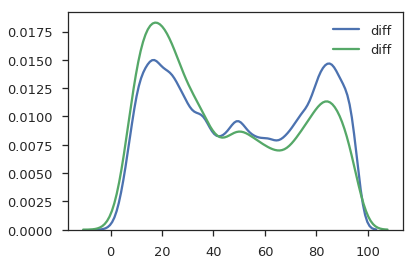

In [62]:
sns.kdeplot(tmp[tmp.TARGET == 0]['diff'])
sns.kdeplot(tmp[tmp.TARGET == 1]['diff']);

### Difference between Days_credit_enddate and Days_enddate_fact for closed loans reported to Bureau.

In [13]:
x = bureau.loc[bureau.CREDIT_ACTIVE == 'Closed', ['SK_ID_CURR', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']]
x.loc[:, 'd'] = x.DAYS_CREDIT_ENDDATE - x.DAYS_ENDDATE_FACT
x = x.groupby('SK_ID_CURR')['d'].sum()
x = app_train.SK_ID_CURR.map(x)
x[x.isnull()].shape[0] / len(x)

0.25152270975672414

In [17]:
x[x>0].shape[0], x[x<0].shape

(146758, (54783,))

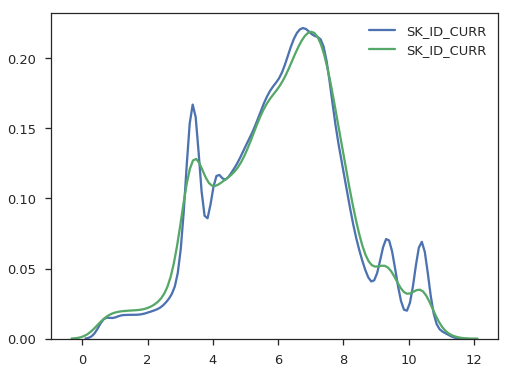

In [19]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x[(x>0) & (app_train.TARGET == 0)].map(np.log1p))
sns.kdeplot(x[(x>0) & (app_train.TARGET == 1)].map(np.log1p));

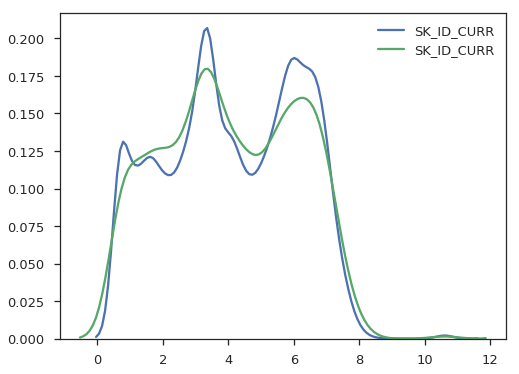

In [20]:
plt.figure(figsize=(8, 6))
sns.kdeplot((-x[(x<0) & (app_train.TARGET == 0)]).map(np.log1p))
sns.kdeplot((-x[(x<0) & (app_train.TARGET == 1)]).map(np.log1p));

### Ratio of Amount Credit to Duration for closed credits.

In [32]:
x = bureau.loc[bureau.CREDIT_ACTIVE == 'Closed', ['SK_ID_CURR', 'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'DAYS_ENDDATE_FACT']]
x.loc[:, 'd'] = x.DAYS_ENDDATE_FACT - x.DAYS_CREDIT
x.loc[:, 'r'] = x.AMT_CREDIT_SUM / x['d']
x = x.groupby('SK_ID_CURR')['r'].median()
x = app_train.SK_ID_CURR.map(x)
x[x.isnull()].shape[0] / len(x)

0.2516202672424726

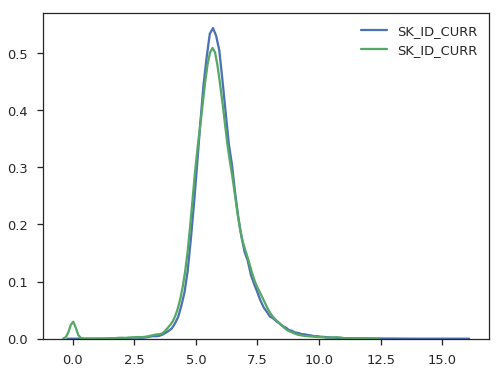

In [33]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x[(app_train.TARGET == 0)].map(np.log1p))
sns.kdeplot(x[(app_train.TARGET == 1)].map(np.log1p));

In [50]:
x = bureau.loc[bureau.CREDIT_ACTIVE == 'Closed', ['SK_ID_CURR', 'AMT_CREDIT_SUM', 'AMT_CREDIT_MAX_OVERDUE']]
x.loc[:, 'r'] = x.AMT_CREDIT_MAX_OVERDUE / x.AMT_CREDIT_SUM

x = x.groupby('SK_ID_CURR')['r'].sum()
x = app_train.SK_ID_CURR.map(x)
x[x.isnull()].shape[0] / len(x)

0.25152270975672414

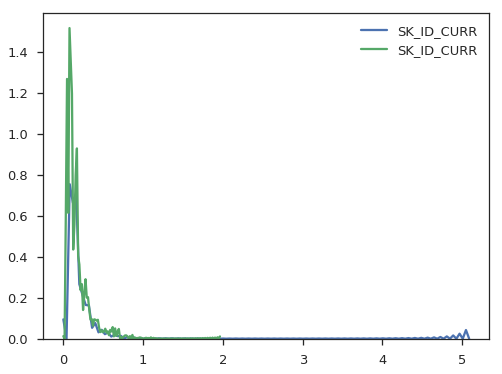

In [51]:
plt.figure(figsize=(8, 6))

sns.kdeplot(x[(app_train.TARGET == 0)].map(np.log1p))
sns.kdeplot(x[(app_train.TARGET == 1)].map(np.log1p));